# Preprocessing

This section is on the preprocessing of the MRI brain scans. The dataset being a combination of others means that there is no consistency in the images formatting, which is why preprocessing is essential. The size of the images are not all the same, so fixing this means that the accuracy of the models will be improved.

In [1]:
import tensorflow as tf
import os
import multiprocessing
import cv2
import copy
from tqdm import tqdm
import time
from math import sqrt
from skimage import io 
from PIL import Image, ImageFilter
import random
import numpy as np
from keras.preprocessing.image import ImageDataGenerator 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torchvision
import torchvision.transforms as transforms
import torch

In [3]:
# Importing and Loading the data into a data frame
dataset_path_train = 'Data/Training/'
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

Due to the demand for memory, I deemed it necessary to make a function that would split the code I run into batches. This is effective at processing and managing massive volumes of data.

In [4]:
def batch_generator(n,batch_size):
    return [[i for i in range(0,n)[j:j+batch_size]] for j in range(0,n,batch_size)]

In [5]:
batch_size = 55

In [6]:
## Importing training
training = {}
for i in tqdm(range(len(class_names))):
    tumor_path_train = os.path.join(dataset_path_train, class_names[i])
    training[class_names[i]] = [Image.open(os.path.join(tumor_path_train, image)) for image in os.listdir(tumor_path_train)]

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.15s/it]


### To Tensor

Once the training data was imported I transformed the images into PyTorch tensor arrays

In [7]:
to_tensor = torchvision.transforms.Compose([transforms.PILToTensor()])
for i in tqdm(range(len(class_names))):
    n = len(training[class_names[i]])
    for batch in batch_generator(n, batch_size):
        for j in batch:
            training[class_names[i]][j] = to_tensor(training[class_names[i]][j])
    print(class_names[i]," processing done!")

 25%|█████████████████████                                                               | 1/4 [00:03<00:09,  3.05s/it]

glioma  processing done!


 50%|██████████████████████████████████████████                                          | 2/4 [00:08<00:08,  4.47s/it]

meningioma  processing done!


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:13<00:04,  4.65s/it]

notumor  processing done!


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.03s/it]

pituitary  processing done!


### 2D to 3D

After noticing that not all of the images had the same dimensions we changed all of the 2D images to 3D. This is so that consistency with the images can be maintained and no issues are encountered when augmentating.

In [8]:
for i in tqdm(range(len(class_names))):
    n = len(training[class_names[i]])
    for batch in batch_generator(n, batch_size):
        for j in batch:
            if len(np.array(training[class_names[i]][j]).shape)==2:
                training[class_names[i]][j] = cv2.cvtColor(training[class_names[i]][j],cv2.COLOR_GRAY2RGB)
    print(class_names[i]," processing done!")

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

glioma  processing done!


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00,  3.92it/s]

meningioma  processing done!


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00,  3.00it/s]

notumor  processing done!


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.55it/s]

pituitary  processing done!


### Resize

In [9]:
x = 0
y = 0
n = 0
for i in range(len(class_names)):
    for j in range(len(training[class_names[i]])):
        x += training[class_names[i]][j].shape[0]
        y += training[class_names[i]][j].shape[1]
        n += 1
av_height = int(y/n)
av_width = int(x/n)
av = int((av_height+av_width)/2)
hav = int(sqrt((av**2)/2))

The dimensions which will be used is the average dimensions of all of the training data, 227 x 227

In [10]:
resize = torchvision.transforms.Compose([torchvision.transforms.Resize((av,av))])
for i in tqdm(range(len(class_names))):
    n = len(training[class_names[i]])
    for batch in batch_generator(n, batch_size):
        for j in batch:
            training[class_names[i]][j] = resize(training[class_names[i]][j])
    print(class_names[i]," processing done!")

 25%|█████████████████████                                                               | 1/4 [00:05<00:15,  5.05s/it]

glioma  processing done!


 50%|██████████████████████████████████████████                                          | 2/4 [00:12<00:12,  6.37s/it]

meningioma  processing done!


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:21<00:07,  7.65s/it]

notumor  processing done!


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:29<00:00,  7.37s/it]

pituitary  processing done!


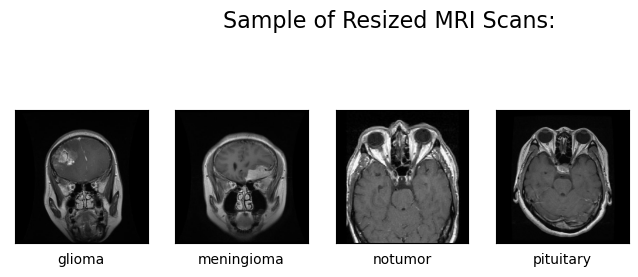

In [11]:
fig = plt.figure(figsize=(10,10))
fig.suptitle("Sample of Resized MRI Scans:", fontsize=16)
for j in range(4):
    plt.subplot(5,5,j+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(training[class_names[j]][0].permute(1, 2, 0))
    plt.xlabel(class_names[j])
plt.show()

## Augmentation

In [12]:
new_training = copy.deepcopy(training)

In [13]:
to_im = torchvision.transforms.ToPILImage()
horizontal_flip = torchvision.transforms.RandomHorizontalFlip(p=1)
blur = torchvision.transforms.GaussianBlur(101, sigma=(0.1, 2.0))
ran_crop = torchvision.transforms.RandomCrop((hav,hav))
rotation = torchvision.transforms.RandomRotation(degrees=(90))

### Random Crop

In [14]:
def random_crop(image):
    cropped_image = ran_crop(image)
    resized = resize(cropped_image)
    resized_image_pil = to_im(resized)
    return resized_image_pil

In [15]:
def randomly_crop(frame):
    classes = list(frame.keys())
    for i in range(len(classes)):
        n = len(frame[classes[i]])
        for batch in batch_generator(n, batch_size):
            for j in batch:
                result = random_crop(frame[classes[i]][j])
                new_training[class_names[i]].append(result)

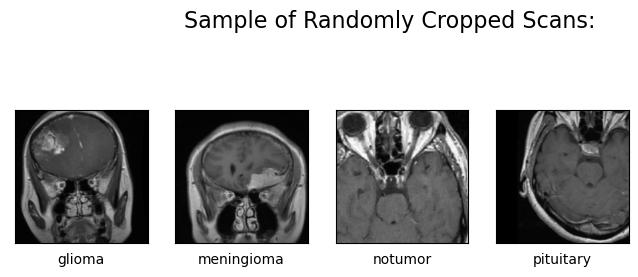

In [16]:
fig = plt.figure(figsize=(10,10))
fig.suptitle("Sample of Randomly Cropped Scans:", fontsize=16)
for j in range(4):
    plt.subplot(5,5,j+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(random_crop(training[class_names[j]][0]))
    plt.xlabel(class_names[j])
plt.show()

### Rotating

In [17]:
def rotating_func(frame):
    classes = list(frame.keys())
    for i in range(len(classes)):
        n = len(frame[classes[i]])
        for batch in batch_generator(n, batch_size):
            for j in batch:
                data = frame[classes[i]][j]
                result = rotation(data)
                new_training[classes[i]].append(result)

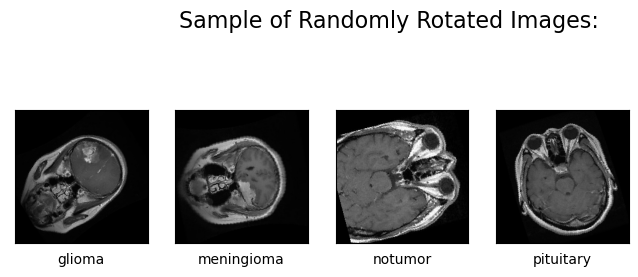

In [18]:
fig = plt.figure(figsize=(10,10))
fig.suptitle("Sample of Randomly Rotated Images:", fontsize=16)
for j in range(4):
    plt.subplot(5,5,j+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(rotation(training[class_names[j]][0]).permute(1, 2, 0))
    plt.xlabel(class_names[j])
plt.show()

In [19]:
if __name__ == "__main__":
    process1 = multiprocessing.Process(target=randomly_crop(training))
    process2 = multiprocessing.Process(target=rotating_func(training))

    process1.start()
    process2.start()

### Training to Images

In [20]:
def ar_to_im(frame):
    classes = list(frame.keys())
    for i in range(len(classes)):
        n = len(frame[classes[i]])
        for batch in batch_generator(n, batch_size):
            for j in batch:
                frame[classes[i]][j] = to_im(frame[classes[i]][j])

### Flipping

In [21]:
def flipping(frame):
    classes = list(frame.keys())
    for i in range(len(classes)):
        n = len(frame[classes[i]])
        for batch in batch_generator(n, batch_size):
            for j in batch:
                data = frame[classes[i]][j]
                result = horizontal_flip(data)
                new_training[classes[i]].append(result)

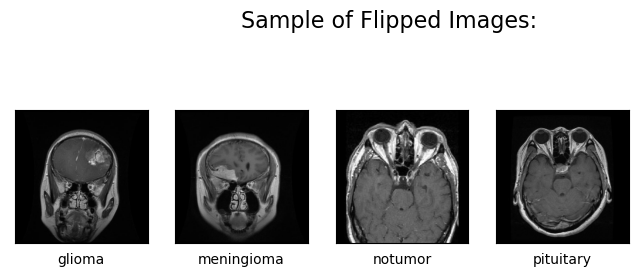

In [22]:
fig = plt.figure(figsize=(10,10))
fig.suptitle("Sample of Flipped Images:", fontsize=16)
for j in range(4):
    plt.subplot(5,5,j+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(horizontal_flip(training[class_names[j]][0]).permute(1, 2, 0))
    plt.xlabel(class_names[j])
plt.show()

### Blur

In [23]:
def blur_image(frame):
    classes = list(frame.keys())
    for i in classes:
        n = len(frame[i])
        for batch in batch_generator(n, batch_size):
            for j in batch:
                blurred_im = blur(frame[i][j])
                new_training[i].append(blurred_im)

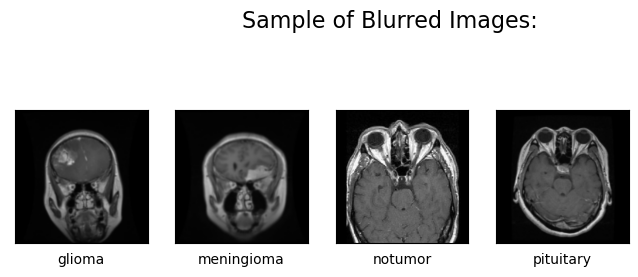

In [24]:
fig = plt.figure(figsize=(10,10))
fig.suptitle("Sample of Blurred Images:", fontsize=16)
for j in range(4):
    plt.subplot(5,5,j+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(blur(training[class_names[j]][0]).permute(1, 2, 0))
    plt.xlabel(class_names[j])
plt.show()

In [25]:
if __name__ == "__main__":
    process3 = multiprocessing.Process(target=flipping(training))
    process4 = multiprocessing.Process(target=blur_image(training))

    process3.start()
    process4.start()

### Augmented Data to Images

Once the augmentation is finished the next step is to transform all of the arrays back to images:

In [26]:
for i in tqdm(range(len(class_names))):
    for batch in batch_generator(len(new_training[class_names[i]]), batch_size):
        for j in batch:
            if type(new_training[class_names[i]][j]) == Image.Image:
                continue
            else:
                new_training[class_names[i]][j]=to_im(new_training[class_names[i]][j])

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:09<00:00, 17.49s/it]
